<a href="https://colab.research.google.com/github/charlie-may86/Book-Model/blob/master/book_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to think about the problem:
Say I want to recommed only books which I think my users will rate as a 4 or 5?
- 4-5 can be true
- < 4 can be false  

I have created a classification problem. 

[Data source can be find here](https://www.kaggle.com/zygmunt/goodbooks-10k?select=ratings.csv)

In [1]:
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap

In [2]:
import io
from google.colab import files
import pandas as pd
import numpy as np
%matplotlib inline
import math
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [3]:
#upload books df
upload = files.upload()

Saving books_unit2_project.csv to books_unit2_project (2).csv


In [4]:
#read in books df
books = pd.read_csv(io.BytesIO(upload['books_unit2_project.csv']), delimiter=',')

In [5]:
#upload ratings df
upload = files.upload()

Saving ratings_unit2_project.csv to ratings_unit2_project (2).csv


In [6]:
#read in ratings df
ratings = pd.read_csv(io.BytesIO(upload['ratings_unit2_project.csv']), delimiter=',')

In [7]:
#create a df that contains user_id and their mean rating
average_ratings = pd.DataFrame(ratings.groupby('user_id')['rating'].mean())

#rename the column in average_ratings so it can be added as a separte column back to ratings
average_ratings.rename(columns={"rating": "average_user_rating"}, inplace=True)
average_ratings

#merge ratings and average_ratings to add in a users average rating
ratings_merged = ratings.merge(average_ratings, left_on='user_id', right_on='user_id')


In [8]:
#check
ratings_merged.head()

,book_id,user_id,rating,average_user_rating
0,1,314,5,3.585635
1,3,314,3,3.585635
2,5,314,4,3.585635
3,6,314,5,3.585635
4,12,314,4,3.585635


In [9]:
#merge ratings df and books df 
df_merged = ratings_merged.merge(books, left_on='book_id', right_on='book_id')
df_merged.head()

,book_id,user_id,rating,average_user_rating,id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,314,5,3.585635,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
1,1,439,3,3.259887,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
2,1,588,5,3.618280,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
3,1,1169,4,3.770053,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...
4,1,1185,4,3.473684,27,1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...


In [10]:
# make a list of ibn13 numbers for future use in improving the model
isbn13_df = books['isbn13'].copy()
isbn13_df = pd.DataFrame(data=isbn13_df)
isbn13_df.head()

,isbn13
0,9.780439e+12
1,9.780440e+12
2,9.780316e+12
3,9.780061e+12
4,9.780743e+12


In [11]:
#drop the columns I know I won't need for the model
df_merged = df_merged.drop(['authors', 'original_title', 'title', 'image_url',
                            'isbn', 'isbn13', 'small_image_url'], axis = 1)

In [12]:
df_merged.shape

(79701, 19)

In [13]:
#check
df_merged.head()

,book_id,user_id,rating,average_user_rating,id,best_book_id,work_id,books_count,original_publication_year,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,1,314,5,3.585635,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
1,1,439,3,3.259887,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
2,1,588,5,3.618280,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
3,1,1169,4,3.770053,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491
4,1,1185,4,3.473684,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491


In [14]:
# creating the new boolean rating column I will attempt to predict
df_merged['read_next'] = np.where(df_merged['rating'] == 5, True, False)
df_merged.head()

,book_id,user_id,rating,average_user_rating,id,best_book_id,work_id,books_count,original_publication_year,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,read_next
0,1,314,5,3.585635,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,True
1,1,439,3,3.259887,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,False
2,1,588,5,3.618280,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,True
3,1,1169,4,3.770053,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,False
4,1,1185,4,3.473684,27,1,41335427,275,2005.0,eng,4.54,1678823,1785676,27520,7308,21516,136333,459028,1161491,False


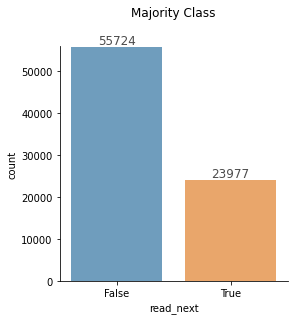

In [59]:
# I am going to create a visual aid which represents the majority class
# I want to do it now so that I have the totals correct
def roundup(x):
  return 100 +int(math.ceil(x/100.0)) * 100

sns.factorplot('read_next', data=df_merged, kind='count',
               alpha=0.7, size=4, aspect=1)

ax=plt.gca()

y_max = df_merged['read_next'].value_counts().max()
ax.set_ylim([0, roundup(y_max)])

for p in ax.patches:
  ax.text(p.get_x() + p.get_width()/2., p.get_height(),
          '%d' % int(p.get_height()),
          fontsize=12, color='black', ha='center', va='bottom', alpha=.7)
  
plt.title('Majority Class', pad=30)
plt.savefig('factor_plot.png', bbox_inches = 'tight', dpi=500)

In [16]:
#split into a two dfs 
#train_val will be split again for training and validation
#test will be held out for testing

# from sklearn.model_selection import train_test_split

train_val, test = train_test_split(df_merged, train_size=0.85, test_size=0.15,
                              stratify=df_merged['read_next'], random_state=42)


In [17]:
#split train_val into a train and test set
train, val = train_test_split(train_val, train_size=0.85, test_size=0.15,
                              stratify=train_val['read_next'], random_state=42)

In [18]:
# making a function to creat a few new columns in each df

def wrangle(X):
  
  #Prevent SettingWithCopyWarning
  X = X.copy()

  #create a new bool column which represents a 5 star rating
  # X['read_next'] = np.where(X['rating'] == 5, True, False)

  #convert original_publication_year to a data
  X['original_publication_year'] = pd.to_datetime(X['original_publication_year'], infer_datetime_format=True)
  
  #Pull year out 
  X['year_published'] = X['original_publication_year'].dt.year
  X = X.drop(columns='original_publication_year')

  #the model can be too picky, and simply never picks 5 stars - dropping columns may help
  # X = X.drop(columns=['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5'])

  #5 star percentage
  X['5_star_percentage'] = X['ratings_5'] / (X['ratings_1'] + X['ratings_2'] + X['ratings_3'] +
                                             X['ratings_4'] + X['ratings_5'])
  


  return(X)

In [19]:
#wrangling my df
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [20]:
#check to make sure majority class is the same
train_wrangled['read_next'].value_counts(normalize=True)

False    0.699165
True     0.300835
Name: read_next, dtype: float64

In [21]:
#look at the data
train_wrangled.head()

,book_id,user_id,rating,average_user_rating,id,best_book_id,work_id,books_count,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,read_next,year_published,5_star_percentage
28885,2156,35301,4,4.166667,230,2156,2534720,1451,eng,4.13,365425,402359,13117,6688,15653,71218,133222,175578,False,1970.0,0.436371
9731,5114,28070,5,3.681159,2339,5114,1839410,89,eng,4.11,36751,40410,1373,360,1483,7692,14592,16283,True,1970.0,0.402945
4801,119,2900,4,4.052632,3230,119,4479,7,en-US,4.59,24340,24412,67,211,220,1751,5011,17219,False,1970.0,0.705350
50260,6750,6446,4,3.813559,6475,6750,1140359,39,NaN,3.84,13011,15312,1229,235,964,3732,6436,3945,False,1970.0,0.257641
37113,6753,15235,4,4.200000,5076,6753,1221616,53,eng,3.88,15555,19502,1460,422,1208,4382,7838,5652,False,1970.0,0.289816


In [22]:
# The read_next column is the target
target = 'read_next'

# Get a dataframe with all train columns except the target
train_features = train_wrangled.drop(columns=[target, 'rating'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [23]:
X_train = train_wrangled[features]
y_train = train_wrangled[target]
X_val = val_wrangled[features]
y_val = val_wrangled[target]
X_test = test_wrangled[features]
y_test = test_wrangled[target]

In [24]:
#check the shape
y_train.shape

(57583,)

In [25]:
#check the df
X_train.head()

,book_id,user_id,average_user_rating,id,best_book_id,work_id,books_count,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,year_published,5_star_percentage,language_code
28885,2156,35301,4.166667,230,2156,2534720,1451,4.13,365425,402359,13117,6688,15653,71218,133222,175578,1970.0,0.436371,eng
9731,5114,28070,3.681159,2339,5114,1839410,89,4.11,36751,40410,1373,360,1483,7692,14592,16283,1970.0,0.402945,eng
4801,119,2900,4.052632,3230,119,4479,7,4.59,24340,24412,67,211,220,1751,5011,17219,1970.0,0.705350,en-US
50260,6750,6446,3.813559,6475,6750,1140359,39,3.84,13011,15312,1229,235,964,3732,6436,3945,1970.0,0.257641,NaN
37113,6753,15235,4.200000,5076,6753,1221616,53,3.88,15555,19502,1460,422,1208,4382,7838,5652,1970.0,0.289816,eng


In [ ]:
!pip install category_encoders==2.*
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
!pip from sklearn.feature_selection import f_regression, SelectKbest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
import category_encoders as ce 

In [ ]:
# do a kmeans clustering based on users and ratings

In [ ]:
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)    

param_distributions = {     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__min_samples_split': range(1, 15),
    'randomforestclassifier__min_samples_leaf': range(1, 20),
    'randomforestclassifier__max_depth': range(3, 20), 
    'randomforestclassifier__max_features': uniform(0, 2)
   
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=30, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

In [40]:
#hyperparameters and score
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 17, 'randomforestclassifier__max_features': 0.3005091968855109, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 13, 'randomforestclassifier__n_estimators': 246, 'simpleimputer__strategy': 'median'}
Cross-validation accuracy 0.7810812296352285


In [41]:
#save the model
model = search.best_estimator_

In [28]:
#save the pipeline
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(criterion='entropy', max_depth=13,
                           max_features=0.2978042480039582, min_samples_leaf=3,
                           min_samples_split=6, n_estimators=78)
)  

In [29]:
#validate the model
pipeline.fit(X_val, y_val)
print(f'Accuracy: {pipeline.score(X_val, y_val)}')

Accuracy: 0.8500295217476874


In [30]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:,.6f}')

Test accuracy: 0.773837


Text(0.5, 1.0, 'NXTbook Scorecard')

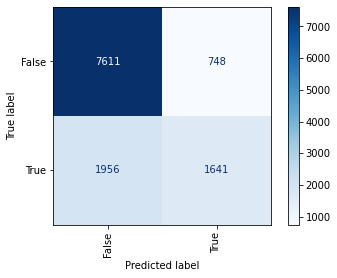

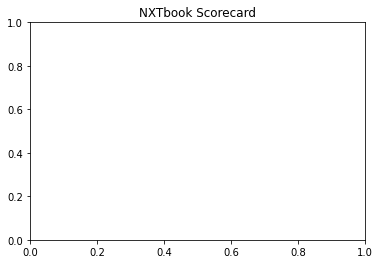

In [32]:
#Check the results
# from sklearn.metrics import plot_confusion_matrix


confusion_matrix = plot_confusion_matrix(pipeline, X_test, y_test,
                                         values_format='.0f', xticks_rotation='vertical', cmap="Blues");
fig = plt.figure()
plt.title('NXTbook Scorecard')

# plt.savefig('confusion.png', dpi=300)

In [33]:
features = ['ratings_count', 'average_rating']

interact = pdp_interact(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


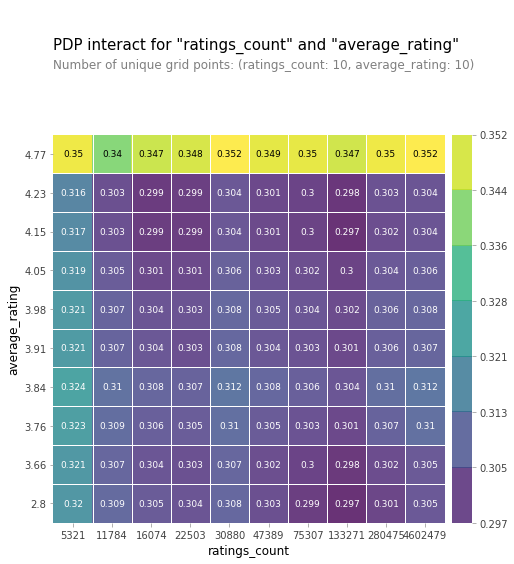

In [34]:
PDP_plot = pdp_interact_plot(interact, plot_type='grid', feature_names=features)

# plt.savefig('PDP_plot.png', dpi=300);

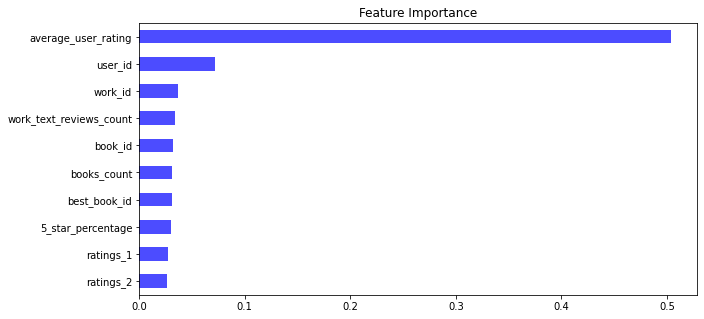

In [64]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_test.columns)

# Plot feature importances
# %matplotlib inline
# import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title('Feature Importance')
importances.sort_values()[-n:].plot.barh(color='blue', alpha=.7)

plt.savefig('feature_importance.png', dpi=300, bbox_inches = 'tight')

In [ ]:
#what is a persons average rating
#what if I only wanted 5 star books
#it is probably more interesting to do only 5 star books

In [ ]:
# What is the average rating for True recommendations that were actually false? 
#Presumably that is something I can find out. 

Results after deleting all the star ratings: 
- True / True = 1406
- Cross-validation accuracy 0.7791362111679936

Results with all the star ratings:
- n_iter=30 
- cv=5 
- True(true) / True(false) = 1420 / 1665

Results after deleting star ratings: 
- n_iter=30 
- cv=5 
- True(true) / True(false) = 1419 / 1666
- False(true) = 568

Results: 
- Model contained all catigories of rating
- n_iter=30 
- cv=5 
- True(true) / True(false) = 1428 / 1657
- False(true) = 571
- Cross-validation accuracy 0.7818974460726661


In [85]:
row = X_test.iloc[[0]]
row

,book_id,user_id,average_user_rating,id,best_book_id,work_id,books_count,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,year_published,5_star_percentage,language_code
26478,8963,33099,4.933333,5497,8963,2507696,64,4.17,19326,21033,433,120,752,3868,6946,9347,1970.0,0.444397,NaN


In [86]:
y_test.iloc[0]


True

In [92]:
model.predict(row)

array([ True])

In [ ]:
!pip install shap
import shap

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap_values